# Regression logistique

In [2]:
# les 3 permiers imports sont les seuls utilisés pour la regression logistique
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import random
import sys

from sklearn.model_selection import KFold # pour la cross validation

### Préparation des données

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [4]:
#def standardize_data(X):
#    # Calcul de la moyenne et l'écart-type pour chaque caractéristique
#    means = np.mean(X, axis=0)
#    std_devs = np.std(X, axis=0)
#
#    # Standardisation : Valeur - moyenne / l'écart-type
#    standardized_X = (X - means) / std_devs
#
#    return standardized_X

In [5]:
#train_data_standard = train_data.copy()
#train_data_standard.iloc[:,1:-1] = standardize_data(train_data_standard.iloc[:,1:-1])
#
#test_data_standard = test_data.copy()
#test_data_standard.iloc[:,1:] = standardize_data(test_data_standard.iloc[:,1:])

 La standardisation est effectuée de manière cohérente entre les ensembles d'entraînement et de test, ce qui permet au modèle de généraliser correctement aux nouvelles données de test. (les paramètres de standardisation (moyenne et écart type) sont calculés uniquement à partir des données d'entraînement et réutilisés pour standardiser les données de test)

In [4]:
# calcul de la moyenne et de l'écart type pour chaque caractéristique à partir des données d'entraînement
mean = np.mean(train_data.iloc[:,1:-1], axis=0)
std = np.std(train_data.iloc[:,1:-1], axis=0)

In [5]:
# standardisation des données d'entraînement en utilisant les paramètres calculés
train_data_standard = train_data.copy()
train_data_standard.iloc[:,1:-1] = (train_data_standard.iloc[:,1:-1] - mean) / std

# standardisation des données de test en utilisant les mêmes paramètres de standardisation
test_data_standard = test_data.copy()
test_data_standard.iloc[:,1:] = (test_data_standard.iloc[:,1:] - mean) / std

In [6]:
# séparation des jeu de test standardisé ou non en 2 sous-ensembles de train et validation
def split_dataset(dataset, split_ratio=0.8):
    """Permet de separer les données en jeux d'entrainement et de validation selon un pourcentage pour le jeu d'entrainement"""

    random.shuffle(dataset) 

    split_index = int(len(dataset) * split_ratio)

    train_set = dataset[:split_index]
    validation_set = dataset[split_index:]

    return pd.DataFrame(train_set), pd.DataFrame(validation_set)


train_set_standard, validation_set_standard = split_dataset(np.array(train_data_standard), split_ratio=0.8)
train_set, validation_set = split_dataset(np.array(train_data), split_ratio=0.8)

### Classe pour le modèle de regression logistique

Source d'inspiration : https://www.kaggle.com/code/vitorgamalemos/multinomial-logistic-regression-from-scratch

In [24]:
class LogisticRegression_habahjkzcnl:
    def __init__(self, learning_rate=0.005, max_epoch=1000, reg=0.1):
        self.learning_rate = learning_rate  # taux d'apprentissage
        self.max_epoch = max_epoch  # nb maximal d'itérations d'entraînement
        self.reg = reg  # terme de régularisation L2
        self.weight = None  # poids du modèle
    
    def predict(self, X):
        X['bias'] = 1
        z = np.dot(X, self.weight)
        probabilities = self.softmax(z)
        return np.argmax(probabilities, axis=1)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        denom = exp_z.sum(axis=1, keepdims=True)
        
        epsilon = 1e-6  # constante pour éviter la division par zéro
        
        return exp_z / (denom + epsilon)

    def one_hot_encode(self, label) :
        e = np.zeros((len(label), len(np.unique(label))))
        for i in range(len(label)) :
            e[i,label[i]] = 1
        return e

    def gradient(self, X, y):
        z = np.dot(X, self.weight)
        # Calcul des probabilités avec la fonction softmax
        probabilities = self.softmax(z)
        # encodage one-hot pour les classes
        y_values = y.values.astype(int)
        one_hot = self.one_hot_encode(y_values)
        # Calcul du gradient de la fonction de coût
        gradient = -np.dot(X.T, (one_hot - probabilities)) / X.shape[0] + self.reg * self.weight
        return gradient

    def compute_loss(self, X, y):
        z = np.dot(X, self.weight)
        probabilities = self.softmax(z)
        y_values = y.values.astype(int)
        one_hot = self.one_hot_encode(y_values)
        epsilon = 1e-6
        loss = -np.sum(one_hot * np.log(probabilities + epsilon)) / X.shape[0]
        # ajout dux terme de régularisation L2
        loss += 0.5 * self.reg * np.sum(self.weight**2)
        return loss

    def compute_error_rate(self, X, y):
        predictions = self.predict(X)
        incorrect_predictions = np.sum(predictions != y)
        error_rate = incorrect_predictions / X.shape[0]
        return error_rate

    def train(self, data_train, data_valid):
        X_train = data_train.iloc[:, 1:-1]
        y_train = data_train.iloc[:, -1] 
        X_train['bias'] = 1

        X_valid = data_valid.iloc[:, 1:-1]
        y_valid = data_valid.iloc[:, -1] 
        X_valid['bias'] = 1
        
        train_losses = []
        train_errors = []
        valid_losses = []
        valid_errors = []

        _, n_features = X_train.shape
        n_classes = len(np.unique(y_train))

        # Initialisation aléatoire des poids
        self.weight = np.random.randn(n_features, n_classes)

        for epoch in range(self.max_epoch):
            # calcul du gradient
            grad = self.gradient(X_train,y_train)
            # maj des poids
            self.weight -= self.learning_rate * grad

            # on calcule et stock la perte (loss) et le taux d'erreur (error rate)
            loss = self.compute_loss(X_train, y_train)
            error = self.compute_error_rate(X_train, y_train)
            train_losses.append(loss)
            train_errors.append(error)

            # pareil avec le jeu de validation
            loss = self.compute_loss(X_valid, y_valid)
            error = self.compute_error_rate(X_valid, y_valid)
            valid_losses.append(loss)
            valid_errors.append(error)


        print("Training completed")
        return np.array(train_losses), np.array(train_errors), np.array(valid_losses), np.array(valid_errors)


def plot_loss_error(train_losses, train_errors, valid_losses, valid_errors):
    '''
        permet de créer 2 figures pour les courbes de perte et les courbes de taux d'erreur
    '''
    plt.figure(figsize=(12, 4))
    
    # courbes de perte
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title("Loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # courbes de taux d'erreur
    plt.subplot(1, 2, 2)
    plt.plot(train_errors, label='Training Error Rate')
    plt.plot(valid_errors, label='Validation Error Rate')
    plt.title("Error Rate over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Error Rate")
    plt.legend()

    plt.show()

In [25]:
class LogisticRegression:
    def __init__(self, learning_rate=0.005, max_epoch=1000, reg=0.1):
        self.learning_rate = learning_rate  # taux d'apprentissage
        self.max_epoch = max_epoch  # nb maximal d'itérations d'entraînement
        self.reg = reg  # terme de régularisation L2
        self.weight = None  # poids du modèle
    
    def predict(self, X):
        X['bias'] = 1
        z = np.dot(X, self.weight)
        probabilities = self.softmax(z)
        return np.argmax(probabilities, axis=1)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        denom = exp_z.sum(axis=1, keepdims=True)
        
        epsilon = 1e-6  # constante pour éviter la division par zéro
        
        return exp_z / (denom + epsilon)

    def one_hot_encode(self, label) :
        e = np.zeros((len(label), len(np.unique(label))))
        for i in range(len(label)) :
            e[i,label[i]] = 1
        return e

    def gradient(self, X, y):
        z = np.dot(X, self.weight)
        # Calcul des probabilités avec la fonction softmax
        probabilities = self.softmax(z)
        # encodage one-hot pour les classes
        y_values = y.values.astype(int)
        one_hot = self.one_hot_encode(y_values)
        # Calcul du gradient de la fonction de coût
        gradient = -np.dot(X.T, (one_hot - probabilities)) / X.shape[0] + self.reg * self.weight
        return gradient

    def compute_loss(self, X, y):
        z = np.dot(X, self.weight)
        probabilities = self.softmax(z)
        y_values = y.values.astype(int)
        one_hot = self.one_hot_encode(y_values)
        epsilon = 1e-6
        loss = -np.sum(one_hot * np.log(probabilities + epsilon)) / X.shape[0]
        # ajout dux terme de régularisation L2
        loss += 0.5 * self.reg * np.sum(self.weight**2)
        return loss

    def compute_accuracy(self, X, y):
        predictions = self.predict(X)
        correct_predictions = np.sum(predictions == y)
        accuracy = correct_predictions / X.shape[0]
        return accuracy

    def train(self, data_train, data_valid):
        X_train = data_train.iloc[:, 1:-1]
        y_train = data_train.iloc[:, -1] 
        X_train['bias'] = 1

        X_valid = data_valid.iloc[:, 1:-1]
        y_valid = data_valid.iloc[:, -1] 
        X_valid['bias'] = 1
        
        train_losses = []
        train_accs = []
        valid_losses = []
        valid_accs = []

        _, n_features = X_train.shape
        n_classes = len(np.unique(y_train))

        # Initialisation aléatoire des poids
        self.weight = np.random.randn(n_features, n_classes)

        for epoch in range(self.max_epoch):
            # calcul du gradient
            grad = self.gradient(X_train,y_train)
            # maj des poids
            self.weight -= self.learning_rate * grad

            # on calcule et stock la perte (loss) et le taux d'erreur (error rate)
            loss = self.compute_loss(X_train, y_train)
            error = self.compute_accuracy(X_train, y_train)
            train_losses.append(loss)
            train_accs.append(error)

            # pareil avec le jeu de validation
            loss = self.compute_loss(X_valid, y_valid)
            error = self.compute_accuracy(X_valid, y_valid)
            valid_losses.append(loss)
            valid_accs.append(error)


        print("Training completed")
        return np.array(train_losses), np.array(train_accs), np.array(valid_losses), np.array(valid_accs)


def plot_loss_acc(train_losses, train_accs, valid_losses, valid_accs):
    '''
        permet de créer 2 figures pour les courbes de perte et les courbes de taux d'erreur
    '''
    plt.figure(figsize=(12, 4))
    
    # courbes de perte
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title("Loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # courbes de taux d'erreur
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(valid_accs, label='Validation Accuracy')
    plt.title("Accuracy over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

### Creation d'un modèle et entraînement

In [26]:
model = LogisticRegression(reg=0.01)

model.learning_rate = 0.01
model.max_epoch = 4000
train_losses, train_errors, valid_losses, valid_errors = model.train(train_set_standard, validation_set_standard)

C:\Users\Prevot\AppData\Local\Temp\ipykernel_14288\744356993.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['bias'] = 1
C:\Users\Prevot\AppData\Local\Temp\ipykernel_14288\744356993.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['bias'] = 1
C:\Users\Prevot\AppData\Local\Temp\ipykernel_14288\744356993.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Training completed


C:\Users\Prevot\AppData\Local\Temp\ipykernel_14288\744356993.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['bias'] = 1
C:\Users\Prevot\AppData\Local\Temp\ipykernel_14288\744356993.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['bias'] = 1


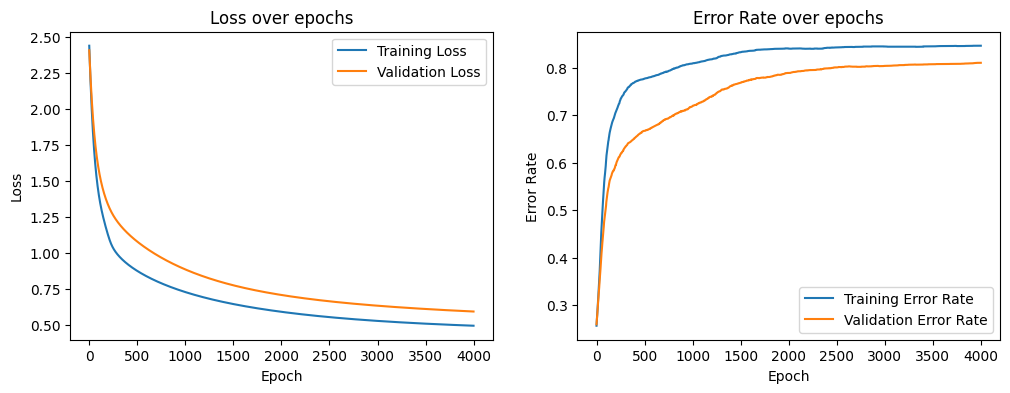

In [27]:
plot_loss_error(train_losses, train_errors, valid_losses, valid_errors)

### Recherche des meilleurs hyperparamètres

In [28]:
# Enlever les ''' pour executer l'optimisation des hyperparamètres

# valeurs à tester pour chaque hyperparamètre
learning_rates = [0.001, 0.005, 0.01]
regs = [0.01, 0.1, 1]
max_epoch = 3000

# Nombre de plis pour la validation croisée
k = 5

best_hyperparameters = None
best_mean_error_rate = float('inf')

for learning_rate in learning_rates:
    for reg in regs:
        # on initialise l'erreur moyenne pour chaque combinaison d'hyperparamètres
        mean_error_rate = 0.0

        for train_idx, valid_idx in KFold(n_splits=k).split(train_data_standard):
            # on sépare les données en données d'entraînement et de validation avec les indices récupérés
            train_fold, valid_fold = train_data_standard.iloc[train_idx], train_data_standard.iloc[valid_idx]

            # on test cette combinaison d'hyperparamètres en entrainant sur les données d'entrainement et en testant sur le jeu de validation
            model = LogisticRegression(learning_rate=learning_rate, max_epoch=max_epoch, reg=reg)
            train_losses, train_errors, valid_losses, valid_errors = model.train(train_fold, valid_fold)

            # on ajoute l'erreur de validation au total
            mean_error_rate += valid_errors[-1]  # (on garde que dernière valeur)

        # on fait une moyenne de l'erreur sur tous les plis
        mean_error_rate /= k

        # si cette combinaison d'hyperparamètres est la meilleure on la garde
        if mean_error_rate < best_mean_error_rate:
            best_mean_error_rate = mean_error_rate
            best_hyperparameters = {'learning_rate': learning_rate, 'reg': reg}

print(f"Meilleurs hyperparamètres : {best_hyperparameters}")


Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed
Training completed


Meilleurs hyperparamètres : {'learning_rate': 0.01, 'reg': 0.1}

### Prédictions

Test sur les données brutes

In [ ]:
model = LogisticRegression(reg=0.01)
model.train(train_set, validation_set)

In [10]:
preds = model.predict(test_data.iloc[:,1:])
predict = pd.DataFrame(preds, columns= ['Label'])
predict['Label'].value_counts()

Label
1    10320
Name: count, dtype: int64

Test sur les données standardisée

In [19]:
preds = model.predict(test_data_standard.iloc[:,1:])
predict = pd.DataFrame(preds, columns= ['Label'])
predict['Label'].value_counts()

Label
1    5061
0    3203
2    2056
Name: count, dtype: int64

Modèle avec données non standardisée

In [16]:
model2 = LogisticRegression(reg=0.01)
model2.train(train_set, validation_set)

C:\Users\Prevot\AppData\Local\Temp\ipykernel_14288\3822639509.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['bias'] = 1
C:\Users\Prevot\AppData\Local\Temp\ipykernel_14288\3822639509.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['bias'] = 1
C:\Users\Prevot\AppData\Local\Temp\ipykernel_14288\3822639509.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Training completed


C:\Users\Prevot\AppData\Local\Temp\ipykernel_14288\3822639509.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['bias'] = 1


(array([7.20924949e+07, 4.90691738e+07, 3.11168591e+07, 1.82347904e+07,
        1.04222179e+07, 7.03329725e+07, 4.97026434e+07, 3.41429620e+07,
        2.36531676e+07, 1.82325096e+07, 8.17441956e+07, 5.58354450e+07,
        3.49981337e+07, 1.92315011e+07, 8.53478668e+06, 2.90723009e+06,
        2.34808059e+06, 5.67199824e+07, 3.56726822e+07, 1.96960923e+07,
        8.78945206e+06, 2.95201177e+06, 7.53499160e+07, 5.66930755e+07,
        4.31065866e+07, 3.45896888e+07, 3.11416313e+07, 7.69405386e+07,
        5.30057652e+07, 3.41421350e+07, 2.03488874e+07, 1.16252621e+07,
        7.97050818e+06, 7.01863066e+07, 4.60432368e+07, 2.69713414e+07,
        1.29698599e+07, 4.03803190e+06, 1.75097026e+05, 1.38030459e+06,
        5.44558433e+07, 3.51726770e+07, 2.09599563e+07, 1.18169314e+07,
        7.68366461e+07, 5.48756199e+07, 3.79854407e+07, 2.61653482e+07,
        1.94145819e+07, 1.77323912e+07, 6.22329670e+07, 4.00638371e+07,
        2.29655857e+07, 1.09374521e+07, 3.97867613e+06, 2.088506

In [17]:
preds = model2.predict(test_data_standard.iloc[:,1:])
predict = pd.DataFrame(preds, columns= ['Label'])
predict['Label'].value_counts()

Label
0    10320
Name: count, dtype: int64

In [18]:
preds = model2.predict(test_data.iloc[:,1:])
predict = pd.DataFrame(preds, columns= ['Label'])
predict['Label'].value_counts()

Label
0    10320
Name: count, dtype: int64